<div id="c-s-hlist">
    <ul>
        <li><a href="#intro">Intro</a></li>
        <li><a href="#import-data">Import Data</a></li>
        <li><a href="#pre-processing">Pre-Processing of Data</a></li>
        <li><a href="#feature-selection">Feature Selection</a></li>
        <li><a href="#generalize-data">Generalize Data</a></li>
        <li><a href="#model-training-and-evaluation">Model Training and Evaluation</a></li>
        <li><a href="#closing-words">Closing words</a></li>
    </ul>
</div>

<h2 id='intro'> Intro </h2>

&emsp;  From <span class="post-content-link"><a href="https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data" target="_blank">House Prices - Advanced Regression Techniques</a></span> this dataset is target to predict a house price and we can specific this is regression problem. And will use XGBoost to predict house price.

<h2 id='import-data'> Import Data </h2>

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# For training set
house_price_path = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
house_price = pd.read_csv(house_price_path, index_col='Id')

# For test set
house_price_test_path = '/kaggle/input/house-prices-advanced-regression-techniques/test.csv'
house_price_test = pd.read_csv(house_price_test_path, index_col='Id')

In [3]:
print(house_price.shape)
house_price.head()

(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
print(house_price_test.shape)
house_price_test.head()

(1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


So from code above, we found the target is a regression problem for this challenge. And I need to copy data for training and testing for not change the original data. That may be we need to use again.

In [5]:
train_raw = house_price.drop(columns=['SalePrice']).copy()
test_raw = house_price_test.copy()
target = house_price['SalePrice'].copy()

<h2 id='pre-processing'> Pre-Processing of Data </h2>

&emsp; In this step, we need to clean a data for make data have a good quality before feature selection and model training and evaluation.

In [6]:
# Check feature data type
train_raw.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

We could see data type is mixing of various types, we will encoding later after we handle missing data.

In [7]:
missing_features_name = train_raw.columns[train_raw.isnull().any()].tolist()
print(missing_features_name)

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


In [8]:
missing_val_features = train_raw.isnull().sum()
missing_features = missing_val_features[missing_val_features > 0]
missing_features = missing_features.to_dict()
missing_features

{'LotFrontage': 259,
 'Alley': 1369,
 'MasVnrType': 872,
 'MasVnrArea': 8,
 'BsmtQual': 37,
 'BsmtCond': 37,
 'BsmtExposure': 38,
 'BsmtFinType1': 37,
 'BsmtFinType2': 38,
 'Electrical': 1,
 'FireplaceQu': 690,
 'GarageType': 81,
 'GarageYrBlt': 81,
 'GarageFinish': 81,
 'GarageQual': 81,
 'GarageCond': 81,
 'PoolQC': 1453,
 'Fence': 1179,
 'MiscFeature': 1406}

So many features are need to handling a missing data before input to machine learning model. Because machine learning model can not interpreter a `Nan` or `inf` value. So we need to hanling this.

- ### Feature analysis

&emsp; Before we imputing a missing value or drop high missing features, we need to analyze features for considering characteristics of data. This helps us decide on a suitable strategy for data pre-processing step.

- **Numeric categorical feature**

In [9]:
numeric_features = train_raw.select_dtypes(include=['float64', 'int64']).columns

# Define a threshold for low cardinality
threshold = 20  # Adjust based on your dataset
# Identify potential categorical features based on low cardinality
# cardinality = train_raw[col].nunique()  # nunique() is find a unique value is not include Nan
potential_categorical_features = [col for col in numeric_features if train_raw[col].nunique() < threshold]
print("Potential categorical features based on cardinality:")
print(potential_categorical_features)

# Calculate the correlation matrix
correlation_matrix = train_raw[numeric_features].corr().abs()
# Set threshold
threshold = 0.2
# Find features that have a correlation lower than the threshold with any other feature
low_corr_features = correlation_matrix.columns[(correlation_matrix < threshold).any()].to_list()
print("\nFeatures likely to be categorical based on correlation threshold:\n", low_corr_features)

# Combined them
numeric_category_features = list(set(potential_categorical_features).union(low_corr_features))

# Cross check with domain knowleadge are found tha not is a categorical, so remove them.
features_to_remove = {
            'TotalBsmtSF', '1stFlrSF', 'OpenPorchSF', 'YrSold', 'BsmtUnfSF', 'YearRemodAdd', 'YearBuilt',
            'LotFrontage', 'BsmtFinSF2','LowQualFinSF', 'GarageArea', 'EnclosedPorch', '3SsnPorch',
            '2ndFlrSF', 'WoodDeckSF', '2ndFlrSF', 'ScreenPorch', 'MiscVal', 'BsmtFinSF1', 'GrLivArea',
            'EnclosedPorch', 'LotArea', 'MasVnrArea', 'PoolArea', 'GarageYrBlt', 'Fireplaces',
            'BsmtFullBath','BsmtHalfBath', 'FullBath', 'HalfBath', 'GarageCars'
} 
numeric_category_features = [feature for feature in numeric_category_features if feature not in features_to_remove]
print("\nNumeric categorical features:",numeric_category_features)

Potential categorical features based on cardinality:
['MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'PoolArea', 'MoSold', 'YrSold']

Features likely to be categorical based on correlation threshold:
 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

Numeric categorical features: ['MSSubClass', 'MoSold', 'OverallCond', 'KitchenAbvGr', 'BedroomAbvGr', 'OverallQual', 'TotRmsAbvGrd']


Then we can found a numerical category features that we need to detect for imputing a missing value for correct method for categorical data.

- **Numeric feature**

In [10]:
numeric_features = list(set(numeric_features).difference(set(numeric_category_features)))
print(f'Nuber of features: {len(numeric_features)}')
print(numeric_features)

Nuber of features: 29
['LotFrontage', '2ndFlrSF', 'YrSold', 'BsmtFullBath', 'MiscVal', 'GarageYrBlt', '1stFlrSF', 'YearRemodAdd', 'MasVnrArea', 'GrLivArea', 'OpenPorchSF', 'WoodDeckSF', 'GarageArea', 'TotalBsmtSF', 'GarageCars', 'LowQualFinSF', '3SsnPorch', 'FullBath', 'EnclosedPorch', 'LotArea', 'BsmtFinSF1', 'BsmtUnfSF', 'YearBuilt', 'HalfBath', 'ScreenPorch', 'BsmtFinSF2', 'PoolArea', 'Fireplaces', 'BsmtHalfBath']


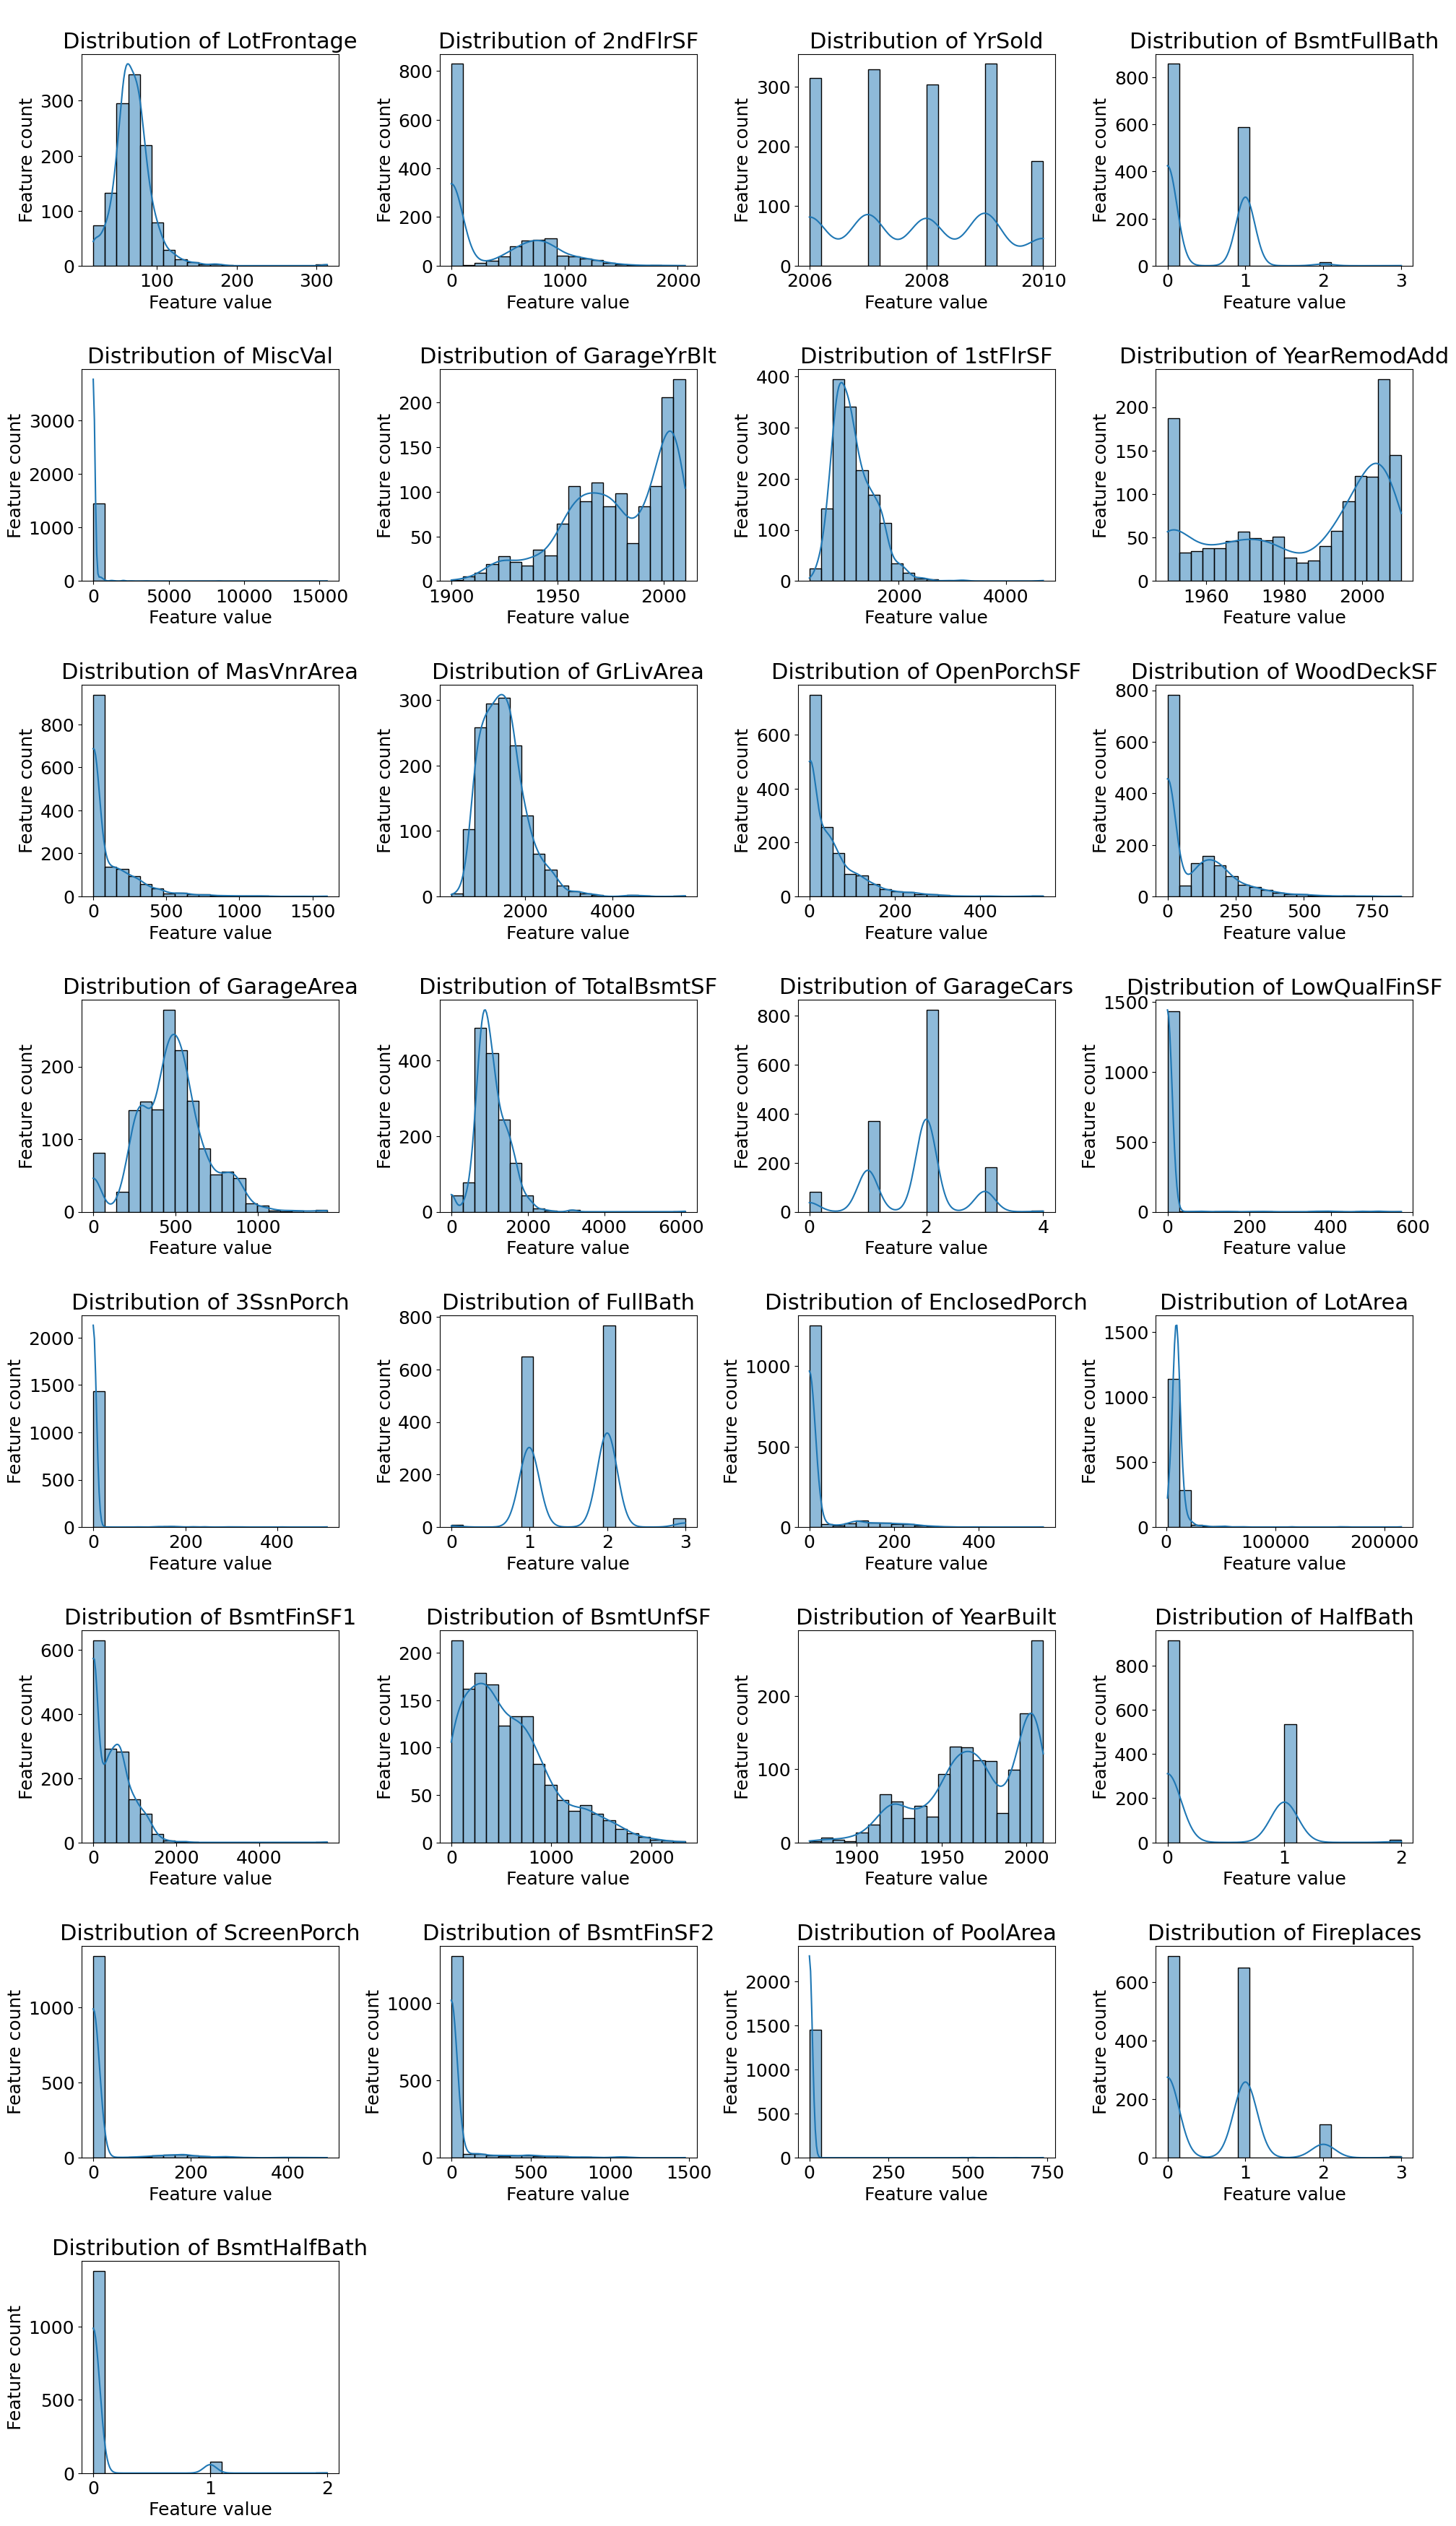

In [11]:
# Plotting a scatter chart of features against the target.
fig, axes = plt.subplots(15, 4, figsize=(20, 5 * 13))
axes = axes.flatten()

for i, feature in enumerate(train_raw[numeric_features]):
    sns.histplot(data=train_raw, x=feature, kde=True, bins=20, ax=axes[i])
    axes[i].set_title(f'\nDistribution of {feature}', fontsize=22)
    axes[i].set_xlabel('Feature value', fontsize=18)
    axes[i].set_ylabel('Feature count', fontsize=18)
    axes[i].tick_params(axis='both', which='major', labelsize=18)  # Major ticks

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

From visualize, feature are diffrenct distribution then we need to consider differrent strategy for imputing a missing value. And seem to many of low varianceg feature that we need to consider in feature selection step.

- **Category feature**

In [12]:
# Match a column dtype = object
category_features = train_raw.select_dtypes(include=['object']).columns
category_features = list(set(category_features).union(set(numeric_category_features)))
print(f'Nuber of features: {len(category_features)}')
print(category_features)

Nuber of features: 50
['MSSubClass', 'Foundation', 'GarageCond', 'Neighborhood', 'Utilities', 'LandSlope', 'Exterior2nd', 'CentralAir', 'MSZoning', 'Fence', 'MoSold', 'BsmtCond', 'OverallCond', 'RoofStyle', 'KitchenQual', 'LandContour', 'BsmtExposure', 'SaleCondition', 'Electrical', 'GarageType', 'Heating', 'Exterior1st', 'KitchenAbvGr', 'LotConfig', 'ExterQual', 'MasVnrType', 'BsmtQual', 'BsmtFinType1', 'MiscFeature', 'BsmtFinType2', 'GarageFinish', 'SaleType', 'BedroomAbvGr', 'PavedDrive', 'Condition2', 'Alley', 'BldgType', 'HouseStyle', 'RoofMatl', 'ExterCond', 'LotShape', 'HeatingQC', 'OverallQual', 'GarageQual', 'Street', 'Functional', 'Condition1', 'TotRmsAbvGrd', 'PoolQC', 'FireplaceQu']


We can see a category data are more than numeric data that seperate category to nominal and ordinal data is beeter for mahcine learning model can interpretation.

In [13]:
nominal_features = [
    'RoofStyle', 'GarageType', 'CentralAir', 'Alley', 'SaleType', 'Street', 'MSSubClass',
    'PavedDrive', 'LandContour', 'Heating', 'Neighborhood', 'GarageFinish', 'MasVnrType',
    'Exterior2nd', 'Foundation', 'LotConfig', 'MSZoning','SaleCondition', 'HouseStyle',
    'Condition1', 'Condition2', 'BldgType', 'Exterior1st', 'RoofMatl', 'Utilities',
    'MiscFeature', 'Electrical'
]


len(nominal_features)

27

In [14]:
ordinal_features = [
    'KitchenAbvGr', 'BsmtQual', 'BsmtFinType2', 'FireplaceQu', 'Fence', 'BedroomAbvGr',
    'GarageQual', 'ExterCond', 'LotShape', 'KitchenQual', 'GarageCond', 'MoSold',
    'HeatingQC', 'OverallQual', 'TotRmsAbvGrd', 'LandSlope', 'BsmtFinType1', 'PoolQC',
    'Functional', 'BsmtCond', 'OverallCond', 'ExterQual', 'BsmtExposure'
]

len(ordinal_features)

23

Then in missing value we can imputing same strategy but in data encoding different ecodinng it's better.

- ### Target distribution

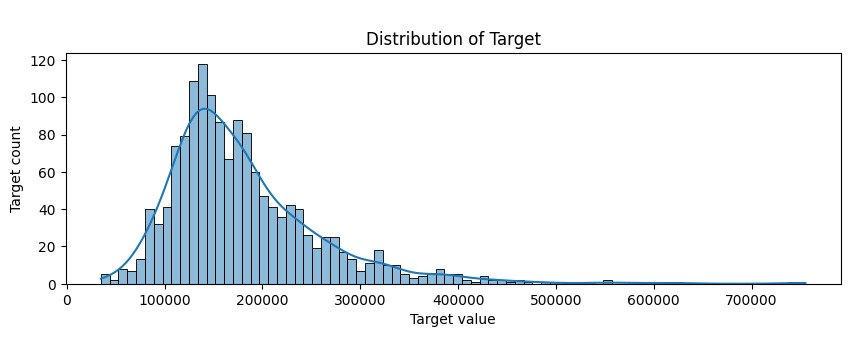

In [15]:
# Check target distribution
# house_price['SalePrice'].hist(bins=80, figsize=(10, 3), grid=False)

plt.figure(figsize=(10, 3))
sns.histplot(target, kde=True, bins=80)
plt.title(f'\nDistribution of Target', fontsize=12)
plt.xlabel('Target value', fontsize=10)
plt.ylabel('Target count', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)  # Major ticks
plt.show()

The data distribution of target seem to skewness type, then asign a log trasnform can make data closed to normal distribtuion. And we will proceed bey `TransformedTargetRegressor` with log function in pipeline model process.

- ### Analysis and hanling a missing data

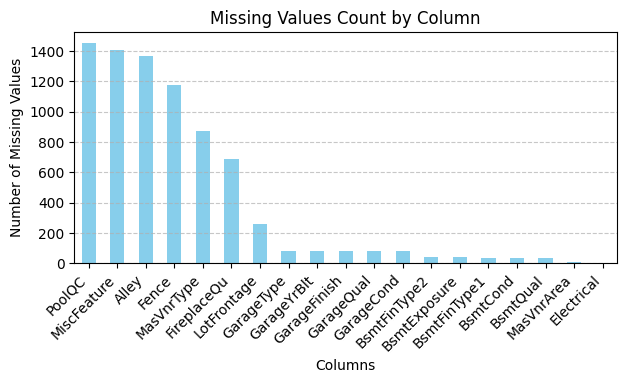


All missing value: 7829


In [16]:
missing_val_column = train_raw.isnull().sum()
missing_columns = missing_val_column[missing_val_column > 0]

# Plot a missing column by count a vlaue
plt.figure(figsize=(7, 3))
missing_columns.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Missing Values Count by Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f'\nAll missing value: {train_raw.isna().sum().sum()}')

From data description we can suctom fill as:

In [17]:
custom_fill = {
    "Alley": "No_alley_access",
    "BsmtQual": "No_Basement",
    "BsmtCond": "No_Basement",
    "BsmtExposure": "No_Basement",
    "BsmtFinType1": "No_Basement",
    "BsmtFinType2": "No_Basement",
    "FireplaceQu": "No_Fireplace",
    "GarageType": "No_Garage",
    "GarageFinish": "No_Garage",
    "GarageQual": "No_Garage",
    "GarageCond": "No_Garage",
    "PoolQC": "No_Pool",
    "Fence": "No_Fence",
    "MiscFeature": "None"
}


train_custom_fill = train_raw.copy()
test_custom_fill = test_raw.copy()

for column, value in custom_fill.items():
    train_custom_fill[column] = train_custom_fill[column].fillna(value)
    test_custom_fill[column] = test_custom_fill[column].fillna(value)

print(f'All missing value after custom fill: {train_custom_fill.isna().sum().sum()}')

All missing value after custom fill: 1221


**Note**: Train and test should same impution stragtegy for prevent test set data leak to trainig process.

Then we need to impute a missing value from different of data distribution.

In [18]:
from sklearn.impute import SimpleImputer
import numpy as np

def handle_missing_data(train_df, test_df=None, missing_threshold=0.5, category_numerical=[]):

    # Drop columns with high missing percentages and not present in training set
    drop_cols = train_df.columns[train_df.isnull().mean() > missing_threshold]
    train_df = train_df.drop(columns=drop_cols)
    if test_df is not None:
        test_df = test_df.drop(columns=drop_cols, errors='ignore')
        # Keep only the columns present in both datasets
        common_cols = train_df.columns.intersection(test_df.columns)
        train_df = train_df[common_cols]
        test_df = test_df[common_cols]

    # Separate columns by type
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns.difference(category_numerical)
    categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.union(category_numerical)

    # Numerical strategy based on skewness
    skew = train_df[numeric_cols].apply(lambda x: x.skew(skipna=True))
    num_strategy = 'median' if skew.abs().max() > 1 else 'mean'

    # Categorical strategy based on mode frequency
    mode_freq = train_df[categorical_cols].apply(lambda x: x.value_counts(normalize=True).max() if x.notnull().any() else 0)
    cat_strategy = 'most_frequent' if mode_freq.max() > 0.5 else 'constant'
    fill_value = "Not_Specified" if cat_strategy == 'constant' else None
    
    # Impute missing values
    num_imputer = SimpleImputer(strategy=num_strategy)
    cat_imputer = SimpleImputer(strategy=cat_strategy, fill_value=fill_value)

    train_df[numeric_cols] = num_imputer.fit_transform(train_df[numeric_cols])
    train_df[categorical_cols] = cat_imputer.fit_transform(train_df[categorical_cols])

    if test_df is not None:
        test_df[numeric_cols] = num_imputer.transform(test_df[numeric_cols])
        test_df[categorical_cols] = cat_imputer.transform(test_df[categorical_cols])
        return train_df, test_df

    return train_df

In [19]:
# Imputing a missing value
train_missing_processed, test_missing_processed = handle_missing_data(
    train_custom_fill, 
    test_custom_fill, 
    missing_threshold=0.4,  
    category_numerical=numeric_category_features
)


print(f"Number of missing value from train set: {train_missing_processed.isna().sum().sum()}")
missing_val_col_train = train_missing_processed.isnull().sum()
missing_col_train = missing_val_col_train[missing_val_col_train > 0]
print(missing_col_train)
print(f'Shape of train set after imputed: {train_missing_processed.shape}')

print(f"\nNumber of missing value from train set: {test_missing_processed.isna().sum().sum()}")
missing_val_col_test = test_missing_processed.isnull().sum()
missing_col_test = missing_val_col_test[missing_val_col_test > 0]
print(missing_col_test)
print(f'Shape of test set after imputed: {test_missing_processed.shape}')

print('\nCheck column if not in train or test of each other.')
print('Columns in train but not in test', set(train_missing_processed.columns) - set(test_missing_processed.columns)) 
print('Columns in test but not in train', set(test_missing_processed.columns) - set(train_missing_processed.columns)) 

Number of missing value from train set: 0
Series([], dtype: int64)
Shape of train set after imputed: (1460, 78)

Number of missing value from train set: 0
Series([], dtype: int64)
Shape of test set after imputed: (1459, 78)

Check column if not in train or test of each other.
Columns in train but not in test set()
Columns in test but not in train set()


So, all missing value are handled and train and test set are present a same features dimension if not we need to create dummy features in test set in encoding step.

- ### Encoding

&emsp; We need to encoding a cetegorycal features string data to numerical value, before input to a model for training for model can interpreter corectly.

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

class DataEncoder:
    def __init__(self, threshold=10, nominal_features=None, ordinal_features=None):
        self.threshold = threshold
        self.label_encoders = {}
        self.onehot_encoders = {}
        self.ordinal_encoders = {}
        self.encoding_types = {}
        self.unique_values = {}
        self.onehot_feature_names = {}
        self.nominal_features = nominal_features or {}
        self.ordinal_features = ordinal_features or {}
        self.category_feature = list(set(self.nominal_features).union(set(ordinal_features)))
    
    def fit(self, data):
        for col in self.category_feature:
            if col not in data.columns:
                continue
            
            unique_vals = data[col].unique()
            self.unique_values[col] = unique_vals
            length = len(unique_vals)
            
            if col in self.ordinal_features:
                self.encoding_types[col] = 'ordinal'
                order = self.ordinal_features[col]
                oe = OrdinalEncoder(categories=[order])
                self.ordinal_encoders[col] = oe.fit(data[[col]])
                
            elif length == 2 or length > self.threshold:
                # Label encoding
                self.encoding_types[col] = 'label'
                le = LabelEncoder()
                self.label_encoders[col] = le.fit(data[col])
                
            else:
                # One-hot encoding for smaller categories
                oe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
                self.encoding_types[col] = 'onehot'
                self.onehot_encoders[col] = oe.fit(data[[col]])
                self.onehot_feature_names[col] = oe.get_feature_names_out([col])
    
    def transform(self, data):
        data_encoded = data.copy()

        for col in self.category_feature:
            if col not in self.encoding_types:
                continue
            
            if self.encoding_types[col] == 'ordinal':
                # Ordinal encoding with predefined order
                data_encoded[col] = self.ordinal_encoders[col].transform(data[[col]])

            
            elif self.encoding_types[col] == 'label':
                # Label encoding with handling of unseen values
                unseen = set(data[col]) - set(self.unique_values[col])
                data_encoded[col] = data[col].map(
                    lambda x: self.label_encoders[col].transform([x])[0] 
                    if x in self.unique_values[col] else -1
                )

            else:
                # One-hot encoding
                dummies = pd.DataFrame(
                    self.onehot_encoders[col].transform(data[[col]]),
                    index=data.index,
                    columns=self.onehot_feature_names[col]
                )
                data_encoded = data_encoded.drop(col, axis=1)
                data_encoded = pd.concat([data_encoded, dummies], axis=1)
            
        return data_encoded

From class <code> DataEncoder</code> will contain seperate method for ensure to fit encoders on training data only. Becuase, we need the same encoding strategy for both of train and test set. This means a categorical features are same encoding label with correct encoded.

In [21]:
for col in ordinal_features:
    print(f"'{col}': {train_missing_processed[col].unique()}")

'KitchenAbvGr': [1 2 3 0]
'BsmtQual': ['Gd' 'TA' 'Ex' 'No_Basement' 'Fa']
'BsmtFinType2': ['Unf' 'BLQ' 'No_Basement' 'ALQ' 'Rec' 'LwQ' 'GLQ']
'FireplaceQu': ['No_Fireplace' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
'Fence': ['No_Fence' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
'BedroomAbvGr': [3 4 1 2 0 5 6 8]
'GarageQual': ['TA' 'Fa' 'Gd' 'No_Garage' 'Ex' 'Po']
'ExterCond': ['TA' 'Gd' 'Fa' 'Po' 'Ex']
'LotShape': ['Reg' 'IR1' 'IR2' 'IR3']
'KitchenQual': ['Gd' 'TA' 'Ex' 'Fa']
'GarageCond': ['TA' 'Fa' 'No_Garage' 'Gd' 'Po' 'Ex']
'MoSold': [2 5 9 12 10 8 11 4 1 7 3 6]
'HeatingQC': ['Ex' 'Gd' 'TA' 'Fa' 'Po']
'OverallQual': [7 6 8 5 9 4 10 3 1 2]
'TotRmsAbvGrd': [8 6 7 9 5 11 4 10 12 3 2 14]
'LandSlope': ['Gtl' 'Mod' 'Sev']
'BsmtFinType1': ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'No_Basement' 'LwQ']
'PoolQC': ['No_Pool' 'Ex' 'Fa' 'Gd']
'Functional': ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
'BsmtCond': ['TA' 'Gd' 'No_Basement' 'Fa' 'Po']
'OverallCond': [5 8 6 7 4 2 3 9 1]
'ExterQual': ['Gd' 'TA' 'Ex' 'Fa']
'BsmtExposure

In [22]:
ordinal_num_features = [
    'KitchenAbvGr', 'BedroomAbvGr', 'MoSold', 'OverallQual', 'TotRmsAbvGrd', 'OverallCond'
]

for col in ordinal_num_features:
    train_missing_processed[col] = train_missing_processed[col].astype('int64')
    test_missing_processed[col] = test_missing_processed[col].astype('int64')
    print(train_missing_processed[col].dtypes, test_missing_processed[col].dtypes)

int64 int64
int64 int64
int64 int64
int64 int64
int64 int64
int64 int64


In [23]:
ordinal_str_features = {
    'BsmtQual': ['No_Basement', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtFinType2': ['No_Basement', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'FireplaceQu': ['No_Fireplace', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['No_Fence', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    'GarageQual': ['No_Garage', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'LotShape': ['IR1', 'IR2', 'IR3', 'Reg'],
    'KitchenQual': ['Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['No_Garage', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'BsmtFinType1': ['No_Basement', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'PoolQC': ['No_Pool', 'Fa', 'Gd', 'Ex'],
    'Functional': ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'BsmtCond': ['No_Basement', 'Po', 'Fa', 'TA', 'Gd'],
    'ExterQual': ['Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['No_Basement', 'No', 'Mn', 'Av', 'Gd']
}

len(ordinal_str_features)

17

In [24]:
DataEncoder
encoder = DataEncoder(threshold=10, 
                      nominal_features=nominal_features, 
                      ordinal_features=ordinal_str_features)
encoder.fit(train_missing_processed)

train_encoded = encoder.transform(train_missing_processed)
print(f'Shape of train set after encoded: {train_encoded.shape}\n')

test_encoded = encoder.transform(test_missing_processed)
print(f'Shape of test set after encoded: {test_encoded.shape}')

print('\nCheck column if not in train or test of each other.')
print('Columns in train but not in test', set(train_encoded.columns) - set(test_encoded.columns))  
print('Columns in test but not in train', set(test_encoded.columns) - set(train_encoded.columns))  

print('Make sure they are all int or float: ', train_encoded.dtypes.unique())
print('Make sure they are all int or float: ', test_encoded.dtypes.unique())

Shape of train set after encoded: (1460, 171)

Shape of test set after encoded: (1459, 171)

Check column if not in train or test of each other.
Columns in train but not in test set()
Columns in test but not in train set()
Make sure they are all int or float:  [dtype('int64') dtype('float64')]
Make sure they are all int or float:  [dtype('int64') dtype('float64')]


So, this can confirm the column names of the train and test sets are the same all names from encoded.

- ### Outlier

&emsp; Outlier handling can significantly impact the performance and accuracy of models. Some models sensitive to extreme values that can lead to biased, noised and istability of model (in case of model rely on distance metrics) that make less accurate predictions. It's suitable for numerical data.

In [25]:
from sklearn.ensemble import IsolationForest

def detect_global_outliers_isolation_forest(dataframe, contamination=0.01):
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    outlier_labels = iso_forest.fit_predict(dataframe)
    
    # Identify outliers (label -1 indicates outlier)
    outliers = np.where(outlier_labels == -1)[0]
    
    print(f"Detected {len(outliers)} global outliers using Isolation Forest.")
    return outliers


# Example usage
global_outliers = detect_global_outliers_isolation_forest(train_encoded[numeric_features].copy())

Detected 15 global outliers using Isolation Forest.


In [26]:
global_outliers

array([  53,  113,  185,  197,  313,  523,  691,  769,  854, 1169, 1173,
       1182, 1298, 1328, 1386])

In [27]:
train_cleaned = train_encoded.copy()
train_cleaned = train_cleaned.drop(index=global_outliers)
train_cleaned.shape

(1445, 171)

In [28]:
# test data need not to eliminate outlier becuase taht data need to predict target
test_cleaned = test_encoded.copy()
test_cleaned.shape

(1459, 171)

In [29]:
y = target.copy()
y = y.drop(index=global_outliers)
y.shape

(1445,)

- ### Data Transformation

&emsp; We will transfrom data with skew distribution to normal distribution with boxcox1p for improve data quality.

In [30]:
import scipy.stats as stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.optimize import minimize_scalar

detect a skew feature that skewness value are more than 1 and -1

In [31]:
skewness_threshold = 1.0
skewness_values = train_cleaned[numeric_features].apply(lambda x: skew(x), axis=0).copy()
skewness_features = skewness_values[abs(skewness_values) > skewness_threshold ]  
skewness_features_list = list(skewness_features.to_dict().keys())

print('Number of skewed feature: ', len(skewness_features))
print('\n',skewness_features)

Number of skewed feature:  17

 TotalBsmtSF       1.528995
ScreenPorch       4.193570
OpenPorchSF       2.366287
BsmtFinSF2        4.260919
GrLivArea         1.370220
WoodDeckSF        1.536889
EnclosedPorch     3.067242
BsmtHalfBath      4.139059
MiscVal          24.325910
LotFrontage       2.432136
BsmtFinSF1        1.696502
PoolArea         14.735801
1stFlrSF          1.382345
LowQualFinSF      8.954026
3SsnPorch        10.437416
LotArea          12.156651
MasVnrArea        2.665948
dtype: float64


In [32]:
before_transform = train_cleaned[skewness_features_list].copy()

Transform data with boxcox1p because this data contain many 0 values, the normal log or boxcox will rasie infinity value occred in this data.

In [33]:
# Helper function for fix random state
def set_random_state(seed):
    np.random.seed(seed)

def find_local_optimal_lambdas(df, random_state=42):
    set_random_state(random_state)
    
    lambdas = {}
    for column in df.columns:
        
        def objective_function(lmbda):
            transformed_col = boxcox1p(df[column], lmbda)
            current_skew = skew(transformed_col)
            return abs(current_skew)
        
        # Try different optimization methods to find the best lambda
        results = []
        methods = ['bounded', 'brent', 'golden']
        
        for method in methods:
            try:
                if method == 'bounded':
                    result = minimize_scalar(objective_function, bounds=(-2, 2), method='bounded')
                else:
                    result = minimize_scalar(objective_function, method=method)
                results.append(result)
            except Exception as e:
                print(f"Method {method} failed for {column}: {e}")
        
        # Select the result with the lowest objective function value
        best_result = min(results, key=lambda x: objective_function(x.x))
        lambdas[column] = best_result.x
    
    return lambdas

In [34]:
local_lambdas = find_local_optimal_lambdas(train_cleaned[skewness_features_list], random_state=0)
print("Local Lambdas:", local_lambdas)

Local Lambdas: {'TotalBsmtSF': 0.69541138394059, 'ScreenPorch': -13.708204216162184, 'OpenPorchSF': 0.03106334644862226, 'BsmtFinSF2': -6.310203350450303, 'GrLivArea': 0.006893229207360772, 'WoodDeckSF': -10.698440380532128, 'EnclosedPorch': -5.960745027044463, 'BsmtHalfBath': -29.799591879447714, 'MiscVal': -4.833923761750958, 'LotFrontage': 0.3554422155888783, 'BsmtFinSF1': 0.49252139807648176, 'PoolArea': -2.8049518479455893, '1stFlrSF': -0.07644360338444138, 'LowQualFinSF': -4.768717899801909, '3SsnPorch': -19.564598507592205, 'LotArea': 0.02697258860655781, 'MasVnrArea': -34.596975089840726}


In [35]:
# Updated transformation with logging
for feature in skewness_features_list:
    opt_lmbda = local_lambdas[feature]  # optimal lambda of each features

    train_skew_before = skew(train_cleaned[feature])
    train_transformed_feature = boxcox1p(train_cleaned[feature], opt_lmbda)
    train_skew_after = skew(train_transformed_feature)

    test_skew_before = skew(test_cleaned[feature])
    test_transformed_feature = boxcox1p(test_cleaned[feature], opt_lmbda)
    test_skew_after = skew(test_transformed_feature)
    
    # Only update if skewness is reduced
    if abs(train_skew_after) < abs(train_skew_before):
        train_cleaned[feature] = train_transformed_feature
    if abs(test_skew_after) < abs(test_skew_before):
        test_cleaned[feature]  = test_transformed_feature

Skewness feature distribution: Before & After of data transformation
 of traning set


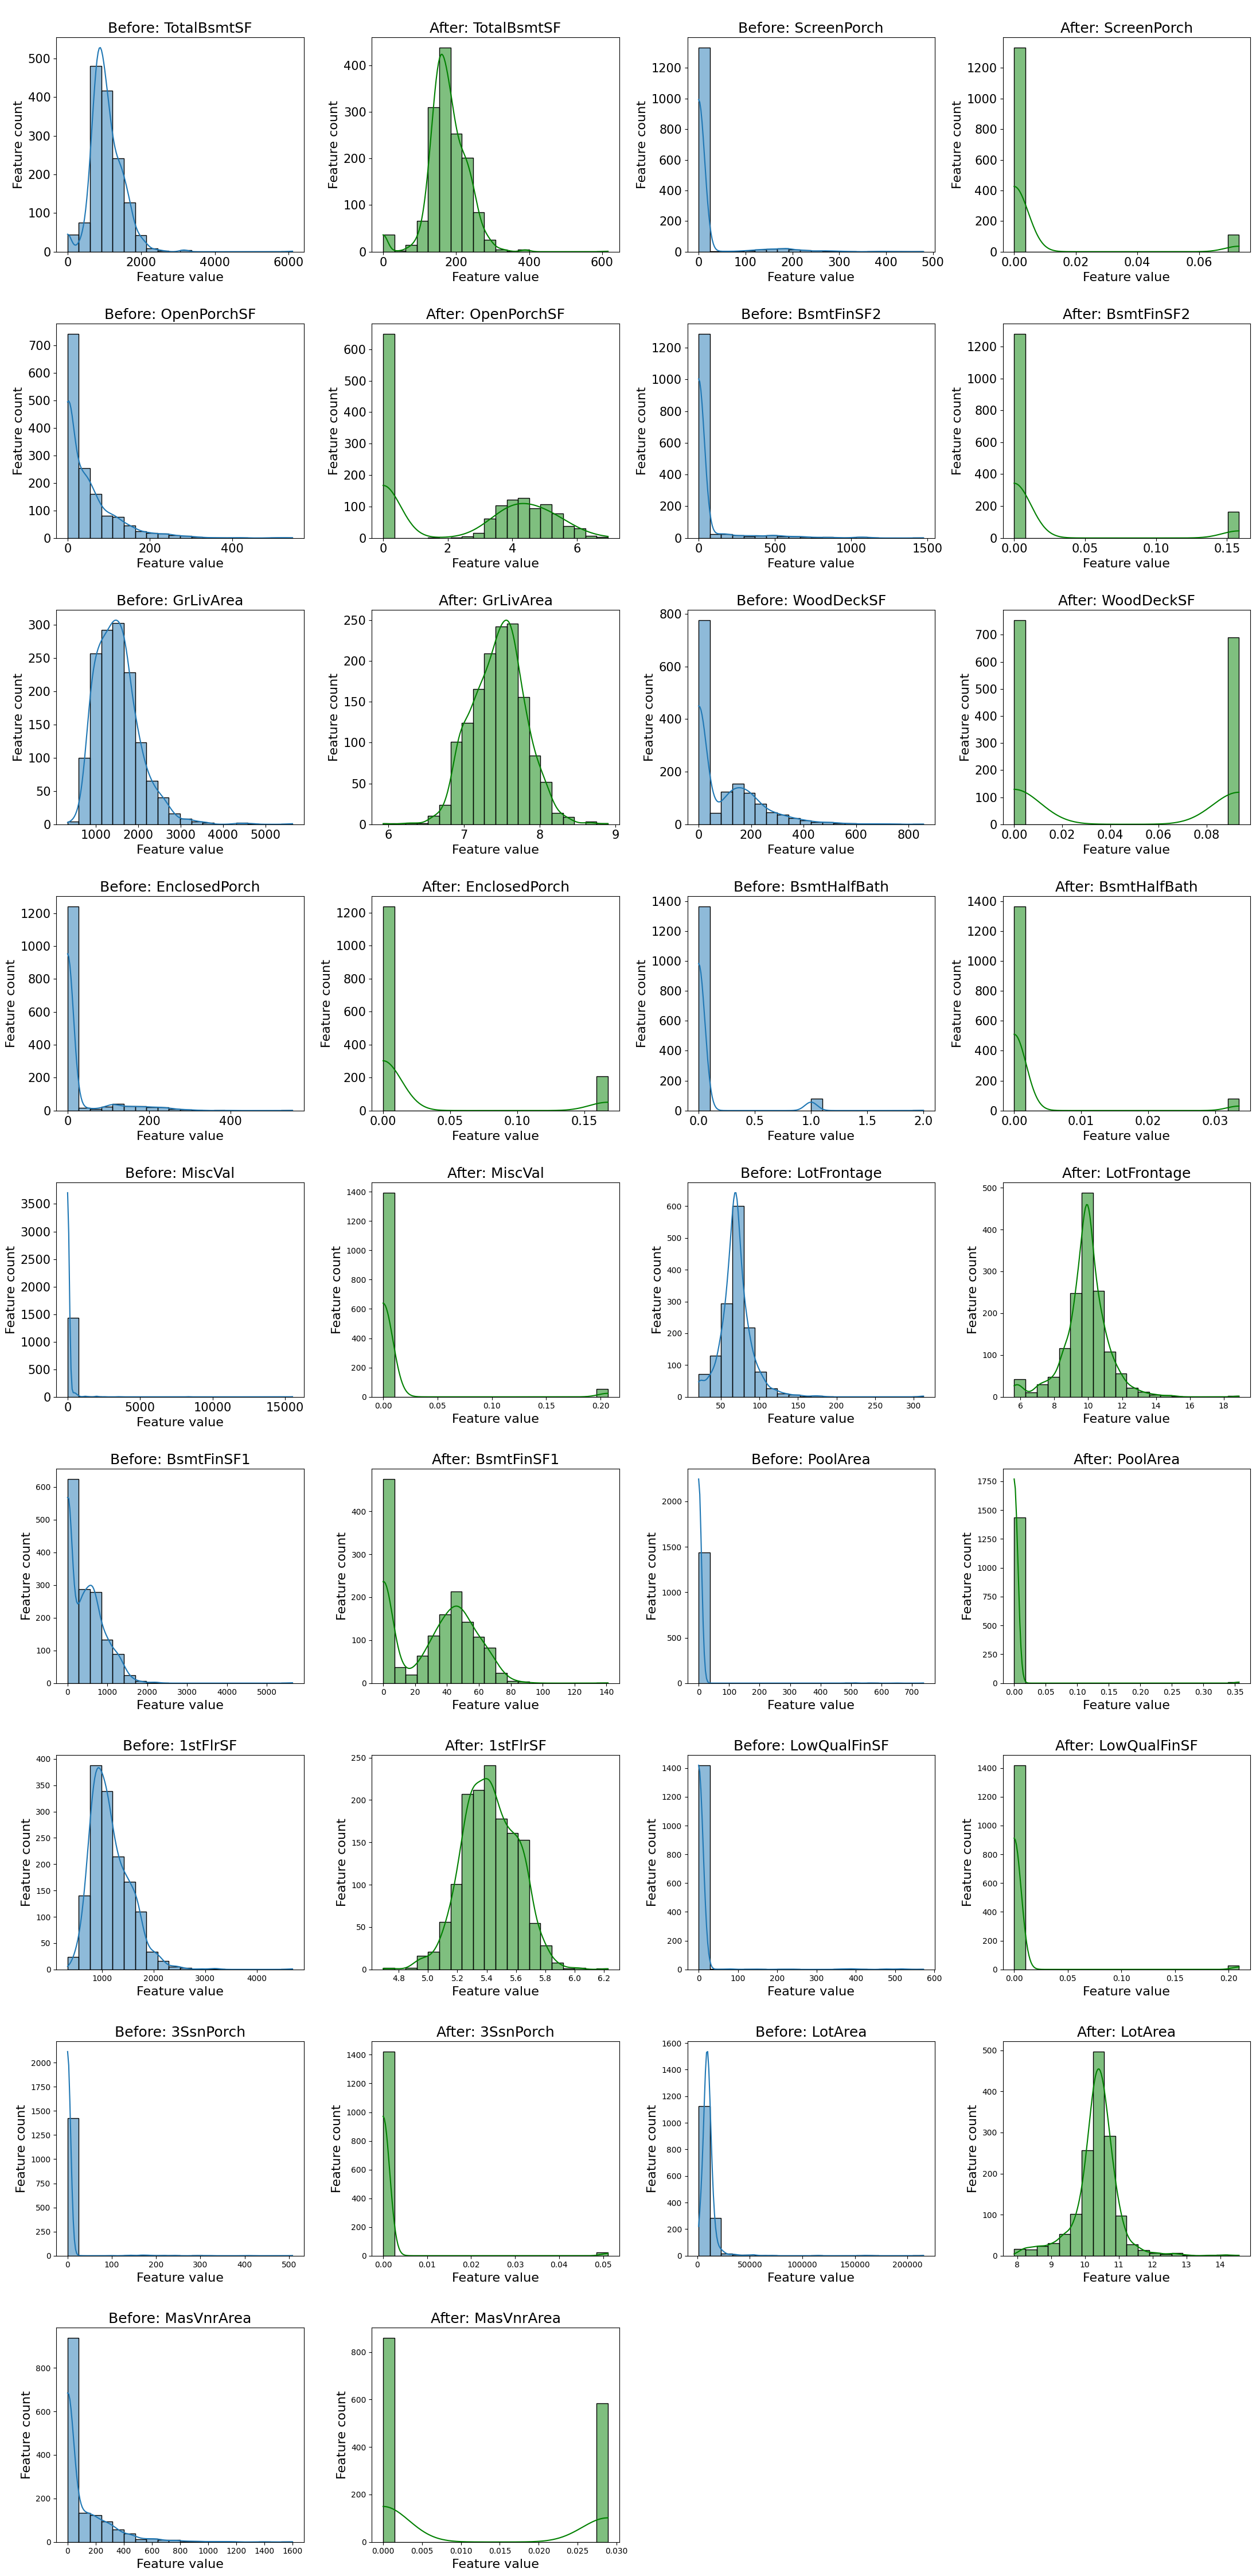

In [36]:
print('Skewness feature distribution: Before & After of data transformation\n of traning set')

# Calculating rows required (two features per row)
num_features = len(skewness_features_list)
num_rows = (num_features + 1) // 2  # Divide by 2 features per row, rounding up

fig, axes = plt.subplots(num_rows, 4, figsize=(22, 5 * num_rows))  
axes = axes.flatten()  # Flatten axes for easier indexing

# Iterating through the features
for i, feature in enumerate(skewness_features_list):
    # Plot "Before" transformation
    sns.histplot(data=before_transform, x=feature, kde=True, bins=20, ax=axes[i * 2])
    axes[i * 2].set_title(f'\nBefore: {feature}', fontsize=18)
    axes[i * 2].set_xlabel('Feature value', fontsize=16)
    axes[i * 2].set_ylabel('Feature count', fontsize=16)
    axes[i].tick_params(axis='both', which='major', labelsize=15)  # Major ticks
    
    # Plot "After" transformation
    sns.histplot(data=train_cleaned, x=feature, kde=True, bins=20, ax=axes[i * 2 + 1], color='green')
    axes[i * 2 + 1].set_title(f'\nAfter: {feature}', fontsize=18)
    axes[i * 2 + 1].set_xlabel('Feature value', fontsize=16)
    axes[i * 2 + 1].set_ylabel('Feature count', fontsize=16)
    axes[i].tick_params(axis='both', which='major', labelsize=15)  # Major ticks

# Hide unused subplots if any
for j in range(i * 2 + 2, len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

<h2 id='feature-selection'> Feature Selection </h2>

&emsp; Selecting an optimal feature can make a model perform faster and optimize it better than selecting all features. And in the same ways, it can reduce a curse of dimensionality in model training.

In [37]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from xgboost import XGBRegressor
import shap
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from concurrent.futures import ThreadPoolExecutor
import warnings
warnings.filterwarnings('ignore')

In [38]:
class EnhancedFeatureSelector:
    def __init__(self, X, y, max_features=200, scaler=RobustScaler()):
        self.X = X
        self.y = y
        self.max_features = max_features
        self.scaler = scaler
        self.feature_scores = {}
        self.optimal_features = None

    def preprocess_data(self):
        """Apply robust scaling or specfict to handle outliers and non-normal distributions"""
        self.X_scaled = pd.DataFrame(
            self.scaler.fit_transform(self.X),
            columns=self.X.columns
        )
        return self.X_scaled

    def lasso_selection(self):
        """Enhanced Lasso with cross-validation and adaptive alpha"""
        lasso = LassoCV(
            cv=5,
            max_iter=2000,
           selection='random',
            n_jobs=-1,
        )
        lasso.fit(self.X_scaled, self.y)
        lasso_importances = pd.Series(np.abs(lasso.coef_), index=self.X.columns)
        lasso_importances = lasso_importances[lasso_importances > 0].nlargest(self.max_features)
        self.feature_scores['lasso'] = lasso_importances
        return lasso_importances

    def mutual_information(self):
        """Mutual Information for non-linear relationships"""
        mi_scores = mutual_info_regression(self.X_scaled, self.y)
        mi_series = pd.Series(mi_scores, index=self.X.columns)
        mi_series = mi_series.nlargest(self.max_features)
        self.feature_scores['mutual_info'] = mi_series
        return mi_series

    def spearman_correlation(self):
        """Spearman correlation for non-normal distributions"""
        # Spearman correlation (resistant to outliers)
        correlations = []
        for column in self.X_scaled.columns:
            correlation, _ = stats.spearmanr(self.X_scaled[column], self.y)
            correlations.append(abs(correlation))

        spearman_scores = pd.Series(correlations, index=self.X.columns)
        spearman_scores = spearman_scores.nlargest(self.max_features)
        self.feature_scores['spearman'] = spearman_scores
        return spearman_scores

    def get_optimal_features(self, threshold=0.5):
        """
        Combine all methods and select optimal features using voting
        threshold: minimum proportion of methods that must select a feature
        """
        # Run all feature selection methods
        self.preprocess_data()
        self.lasso_selection()
        self.mutual_information()
        self.spearman_correlation()

        # Create a voting system
        all_features = set()
        feature_votes = {}

        for method_name, scores in self.feature_scores.items():
            features = scores.index.tolist()
            for feature in features:
                if feature not in feature_votes:
                    feature_votes[feature] = 0
                feature_votes[feature] += 1
                all_features.add(feature)

        # Select features that appear in multiple methods
        n_methods = len(self.feature_scores)
        min_votes = max(2, int(n_methods * threshold))  # Feature must appear in at least 2 methods

        selected_features = [
            feature for feature, votes in feature_votes.items()
            if votes >= min_votes
        ]

        # Sort features by average importance across methods
        feature_importance = {}
        for feature in selected_features:
            importance_scores = []
            for scores in self.feature_scores.values():
                if feature in scores:
                    importance_scores.append(scores[feature])
            feature_importance[feature] = np.mean(importance_scores)

        sorted_features = sorted(
            feature_importance.items(),
            key=lambda x: x[1],
            reverse=True
        )

        self.optimal_features = [feature for feature, _ in sorted_features]
        return self.optimal_features

    def evaluate_feature_set(self, features):
        """Evaluate the performance of selected features using cross-validation"""
        X_selected = self.X_scaled[features]
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        scores = cross_val_score(
            model, X_selected, self.y,
            cv=5,
            scoring=make_scorer(mean_squared_error)
        )
        return -scores.mean()  # Return negative MSE (higher is better)

    def find_optimal_feature_count(self, min_features=5, step=5):
        """Find the optimal number of features using cross-validation"""
        if self.optimal_features is None:
            self.get_optimal_features()

        best_score = float('-inf')
        best_count = min_features
        print("\nStarting evaluate feature......")

        for n_features in range(min_features, len(self.optimal_features) + 1, step):
            features = self.optimal_features[:n_features]
            score = self.evaluate_feature_set(features)

            if score > best_score:
                best_score = score
                best_count = n_features
            elif n_features > best_count + step * 2:  # Early stopping
                break

        print("......Best feature has been selected")
        return self.optimal_features[:best_count]


    def compare_method_performance(self):
        """Compare performance of different feature selection methods"""
        results = []
        cache = {}  # Cache for storing evaluation results

        # Ensure feature_scores is populated
        if not self.feature_scores:
            self.get_optimal_features()

        # Helper function to evaluate a feature set, with caching
        # to avoid recall evaluate_feature_set() that needs time consumming
        def evaluate_cached(features):
            features_tuple = tuple(features)
            if features_tuple not in cache:
                cache[features_tuple] = -self.evaluate_feature_set(features)
            return cache[features_tuple]

        # Use ThreadPoolExecutor to parallelize evaluations
        with ThreadPoolExecutor() as executor:
            futures = []
            for method_name, selected_features in self.feature_scores.items():
                features = selected_features.index.tolist()[:self.max_features]
                n_features = len(features)
                # Submit evaluation to the executor
                futures.append(
                    executor.submit(
                        lambda m=method_name, f=features, n=n_features: {
                            'method': m,
                            'n_features': n,
                            'score': evaluate_cached(f),
                            'features': f
                        }
                    )
                )

            # Collect results from the futures
            for future in futures:
                results.append(future.result())

        return pd.DataFrame(results)

In [39]:
# Initialize EnhancedFeatureSelector class with paarameter

# Scaler in model should same method in here because even perform well in validation set
# but feature that selected form other scaler then will perform bad in unseen data
selector = EnhancedFeatureSelector(train_cleaned, y, len(train_cleaned.columns),
                                   scaler=StandardScaler())

start_time = time.time()
# Compare performance of different methods
performance_comparison = selector.compare_method_performance()
print("\nMethod Performance Comparison:")
print(performance_comparison[['method', 'n_features', 'score']])

# Get automatically selected features
optimal_features = selector.find_optimal_feature_count(
    min_features=5,  # minimum features to consider
    step=5          # step size for feature count optimization
)

training_time = time.time() - start_time
hours, remainder = divmod(training_time, 3600)
minutes, seconds = divmod(remainder, 60)

# Access selected features
print(f"\nSelected {len(optimal_features)} features: {optimal_features}")

print(f"\nUsage time is {int(hours):02}:{int(minutes):02}:{int(seconds):02} (hh:mm:ss).")


Method Performance Comparison:
        method  n_features         score
0        lasso          64  8.988063e+08
1  mutual_info         171  9.056209e+08
2     spearman         171  8.917593e+08

Starting evaluate feature......
......Best feature has been selected

Selected 45 features: ['2ndFlrSF', 'OverallQual', '1stFlrSF', 'RoofMatl_ClyTile', 'TotalBsmtSF', 'BsmtFinSF1', 'ExterQual', 'GarageArea', 'KitchenQual', 'SaleType_New', 'TotRmsAbvGrd', 'Condition2_PosN', 'LotArea', 'BsmtExposure', 'BsmtQual', 'RoofMatl_WdShngl', 'BsmtCond', 'BedroomAbvGr', 'OverallCond', 'Fireplaces', 'Foundation_Slab', 'MSSubClass', 'PoolQC', 'GarageFinish_No_Garage', 'RoofStyle_Hip', 'Functional', 'Condition1_Norm', 'KitchenAbvGr', 'GarageCars', 'LotConfig_CulDSac', 'FullBath', 'Heating_OthW', 'Exterior1st', 'GarageFinish_Fin', 'Foundation_PConc', 'HalfBath', 'GarageType_BuiltIn', 'SaleCondition_Abnorml', 'GarageFinish_RFn', 'MSZoning_C (all)', 'Neighborhood', 'GarageType_2Types', 'LandContour_HLS', 'Hous

<h2 id='generalize-data'> Generalize Data</h2>

In [40]:
X = train_cleaned[optimal_features].copy()
# y already definded
X_test = test_cleaned[optimal_features].copy()


print('X', X.shape, 'y', y.shape, 'X_sub', X_test.shape)

X (1445, 45) y (1445,) X_sub (1459, 45)


In [41]:
from sklearn.model_selection import train_test_split

# If use a cross validation we need not to split a data
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=42)

<h2 id='model-training-and-evaluation'> Model Training and Evaluation </h2>

In [42]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.compose import TransformedTargetRegressor
from tabulate import tabulate

- ### ModeL Selection

In [43]:
def run_base_model(X_train, y_train, X_val, y_val, base_models):
    results = {
        'Models': [],
        'RMSE': [],
        'MAE': [],
        'R2': [],
        'RMSLE': [],
        'Time Usage (hh:mm:ss)': []
    }

    print("Starting run base model...\n")
    
    for name, model in base_models:        
        print(f"Running model: {name}")
        start_time = time.time()
        
        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        # Calculate time usage
        time_usage = time.time() - start_time
        hours, remainder = divmod(time_usage, 3600)
        minutes, seconds = divmod(remainder, 60)
        re_format_TU = f'{int(hours):02}:{int(minutes):02}:{int(seconds):02}'
        
        # Metrics calculations
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        rmsle = np.sqrt(mean_squared_error(np.log1p(y_val), np.log1p(np.clip(y_pred, a_min=0, a_max=None))))
        
        # Append results
        results['Models'].append(name)
        results['RMSE'].append(rmse)
        results['MAE'].append(mae)
        results['R2'].append(r2)
        results['RMSLE'].append(rmsle)
        results['Time Usage (hh:mm:ss)'].append(re_format_TU)
    
    # Create DataFrame after all models have been evaluated
    results_df = pd.DataFrame(results).sort_values(by='RMSE')
    
    # Display results with formatted output
    pd.options.display.float_format = '{:.4f}'.format
    
    # Convert DataFrame to tabulate table
    table = tabulate(results_df, headers='keys', tablefmt='grid')
    print("\nEvaluation of Different Models:")
    print(table)
    
    return results_df

In [44]:
lasso = make_pipeline( StandardScaler(),
    TransformedTargetRegressor( regressor=LassoCV(), func=np.log1p, inverse_func=np.expm1) )

ridge = make_pipeline( StandardScaler(),
    TransformedTargetRegressor( regressor=RidgeCV(), func=np.log1p, inverse_func=np.expm1) )

elasticNet = make_pipeline( StandardScaler(),
    TransformedTargetRegressor( regressor=ElasticNetCV(), func=np.log1p, inverse_func=np.expm1) )

ds = make_pipeline( StandardScaler(),
    TransformedTargetRegressor( regressor=DecisionTreeRegressor(), func=np.log1p, inverse_func=np.expm1) )

extree = make_pipeline( StandardScaler(),
    TransformedTargetRegressor( regressor=ExtraTreeRegressor(), func=np.log1p, inverse_func=np.expm1) )

rf = make_pipeline( StandardScaler(),
    TransformedTargetRegressor( regressor=RandomForestRegressor(), func=np.log1p, inverse_func=np.expm1) )

ada = make_pipeline( StandardScaler(),
    TransformedTargetRegressor( regressor=AdaBoostRegressor(), func=np.log1p, inverse_func=np.expm1) )

gbf = make_pipeline( StandardScaler(),
    TransformedTargetRegressor( regressor=GradientBoostingRegressor(), func=np.log1p, inverse_func=np.expm1) )

xgb = make_pipeline( StandardScaler(),
    TransformedTargetRegressor( regressor=XGBRegressor(), func=np.log1p, inverse_func=np.expm1) )

lgbm = make_pipeline( StandardScaler(),
    TransformedTargetRegressor( regressor=LGBMRegressor(verbosity=-1), func=np.log1p, inverse_func=np.expm1) )

catbt = make_pipeline( StandardScaler(),
    TransformedTargetRegressor( regressor=CatBoostRegressor(verbose=0), func=np.log1p, inverse_func=np.expm1) )

knn = make_pipeline( StandardScaler(),
    TransformedTargetRegressor( regressor=KNeighborsRegressor(), func=np.log1p, inverse_func=np.expm1) )

svr = make_pipeline( StandardScaler(),
    TransformedTargetRegressor( regressor=SVR(), func=np.log1p, inverse_func=np.expm1) )

models_comparing = [
    ('LassoRegression', lasso),
    ('RidgeRegression', ridge),
    ('ElasticNet', elasticNet),
    ('DecissionTree', ds ),
    ('ExtraTree', extree),
    ('RandomForestRegressor', rf),
    ('AdaBoost', ada),
    ('GradientBoost', gbf),
    ('XGBRegressor', xgb),
    ('LightBGM', lgbm),
    ('CatBoost', catbt),
    ('KNN', knn),
    ('SVR', svr),
]

start_time = time.time()

# Evaluate models using run_base_model
models_comparing_result = run_base_model(X_train, y_train, X_validate, y_validate, models_comparing)

training_time = time.time() - start_time
hours, remainder = divmod(training_time, 3600)
minutes, seconds = divmod(remainder, 60)

print(f"\nModel training completed, usage time is {int(hours):02}:{int(minutes):02}:{int(seconds):02} (hh:mm:ss).")

Starting run base model...

Running model: LassoRegression
Running model: RidgeRegression
Running model: ElasticNet
Running model: DecissionTree
Running model: ExtraTree
Running model: RandomForestRegressor
Running model: AdaBoost
Running model: GradientBoost
Running model: XGBRegressor
Running model: LightBGM
Running model: CatBoost
Running model: KNN
Running model: SVR

Evaluation of Different Models:
+----+-----------------------+---------+---------+----------+----------+-------------------------+
|    | Models                |    RMSE |     MAE |       R2 |    RMSLE | Time Usage (hh:mm:ss)   |
+====+=======================+=========+=========+==========+==========+=========================+
|  1 | RidgeRegression       | 21197.8 | 14209   | 0.923362 | 0.11561  | 00:00:00                |
+----+-----------------------+---------+---------+----------+----------+-------------------------+
| 10 | CatBoost              | 21860   | 13881.8 | 0.918499 | 0.122418 | 00:00:01                |

So to prevent the model from being too complex and overfitting to new unseen data, we will choose a model with top 3 model of high score or minimum loss from all models. 

- ### Model training with stacking and blending

&emsp; We need to stacking a model that is better than use 1 model to more preformance of prediction model. But Stacking can sometimes overfit the meta-model to the validation data used during training. So, Blending introduces a weighted average of predictions from the stacked model and potentially other models or approaches, reducing the dependency on any single meta-model.
That blending a model can help a stacking model more flexible and prevent overfiting.

In [45]:
# A folt to spit
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

alphas_ridge =  np.arange(0.01, 1, 0.01).tolist()

ridgeCV = make_pipeline(
    StandardScaler(),
    TransformedTargetRegressor( regressor=RidgeCV( alphas=alphas_ridge, cv=kfolds ),
        func=np.log1p,
        inverse_func=np.expm1
    )
)

catboost_regr = make_pipeline(
    StandardScaler(),
    TransformedTargetRegressor( 
        regressor=CatBoostRegressor(verbose=0), # Disable verbose logging
        func=np.log1p,
        inverse_func=np.expm1,
    )
)

lightgbm = make_pipeline(
    StandardScaler(),
    TransformedTargetRegressor(
        regressor=LGBMRegressor( objective='regression', num_leaves=4, learning_rate=0.01, 
                                n_estimators=5000, max_bin=200, bagging_fraction=0.75, bagging_freq=5, 
                                bagging_seed=7, feature_fraction=0.2, feature_fraction_seed=7, verbose=-1 ),
        func=np.log1p,
        inverse_func=np.expm1
    )
)


l0_models = [
    ('RidgeCV', ridgeCV),
    ('CatBoostRegressor', catboost_regr),
    ('LightBGM', lightgbm),
    
]

meta_model = RidgeCV( alphas=alphas_ridge, cv=kfolds)       
stacking_regr = StackingRegressor(estimators=l0_models, final_estimator=meta_model)

# Base models
base_models = [
    ('RidgeCV', ridgeCV),
    ('CatBoostRegressor', catboost_regr),
    ('LightBGM', lightgbm),
    ('StackingRegressor', stacking_regr)
]

start_time = time.time()

# Evaluate models using run_base_model
best_models_set = run_base_model(X_train, y_train, X_validate, y_validate, base_models)

training_time = time.time() - start_time
hours, remainder = divmod(training_time, 3600)
minutes, seconds = divmod(remainder, 60)

print(f"\nModel training completed, usage time is {int(hours):02}:{int(minutes):02}:{int(seconds):02} (hh:mm:ss).")

Starting run base model...

Running model: RidgeCV
Running model: CatBoostRegressor
Running model: LightBGM
Running model: StackingRegressor

Evaluation of Different Models:
+----+-------------------+---------+---------+----------+----------+-------------------------+
|    | Models            |    RMSE |     MAE |       R2 |    RMSLE | Time Usage (hh:mm:ss)   |
+====+===================+=========+=========+==========+==========+=========================+
|  0 | RidgeCV           | 21223.9 | 14235.5 | 0.923173 | 0.1157   | 00:00:02                |
+----+-------------------+---------+---------+----------+----------+-------------------------+
|  1 | CatBoostRegressor | 21860   | 13881.8 | 0.918499 | 0.122418 | 00:00:01                |
+----+-------------------+---------+---------+----------+----------+-------------------------+
|  3 | StackingRegressor | 22654   | 14212.8 | 0.912471 | 0.128138 | 00:00:30                |
+----+-------------------+---------+---------+----------+---------

In [46]:
from scipy.optimize import minimize

def blending_model(X_val, y_val, base_models):
    # Step 1: Get predictions from all base models
    base_predictions = []
    for name, model in base_models:
        preds = model.predict(X_val)  # Predict on the validation set
        base_predictions.append(preds)
    
    # Convert predictions to a matrix (each column is predictions from a base model)
    base_predictions = np.column_stack(base_predictions)
    
    # Step 2: Optimize weights for blending
    def loss_function(weights):
        blended_preds = np.dot(base_predictions, weights)  # Weighted sum of predictions
        return np.sqrt(mean_squared_error(y_val, blended_preds))  # RMSE

    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Constraints: Weights must sum to 1
    bounds = [(0, 1)] * base_predictions.shape[1]  # Bounds: Weights must be between 0 and 1
    initial_weights = [1 / base_predictions.shape[1]] * base_predictions.shape[1]  # Initial weights (equal weights)
    result = minimize(loss_function, initial_weights, constraints=constraints, bounds=bounds)  # Optimize weights using scipy

    # Step 3: Get optimized weights
    optimized_weights = result.x
    print("Optimized Weights:", optimized_weights)

    # Step 4: Define the blended model as a simple weighted average of base models
    def blended_model(X):
        base_preds = []
        for name, model in base_models:
            preds = model.predict(X)  # Predict on the input X using the base model
            base_preds.append(preds)
        base_preds = np.column_stack(base_preds)
        return np.dot(base_preds, optimized_weights)  # Weighted sum of predictions

    # Step 5: Calculate RMSE for the blended model
    blended_predictions = blended_model(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, blended_predictions))
    mae = mean_absolute_error(y_val, blended_predictions)
    r2 = r2_score(y_val, blended_predictions)
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_val), np.log1p(np.clip(blended_predictions, a_min=0, a_max=None))))
    
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"RMSLE: {rmsle:.4f}")
    
    return blended_model, optimized_weights

In [47]:
start_time = time.time()
print("Starting run blending model...\n")

# Run the blending model function
blended_model, optimized_weights = blending_model(X_validate, y_validate, base_models)

training_time = time.time()- start_time
hours, remainder = divmod(training_time, 3600)
minutes, seconds = divmod(remainder, 60)

print(f"\nModel are blended, usage time is {int(hours):02}:{int(minutes):02}:{int(seconds):02} (hh:mm:ss).")

Starting run blending model...

Optimized Weights: [6.27950553e-01 3.72049424e-01 2.49104347e-08 2.59716902e-12]
RMSE: 20871.7407
MAE: 13751.3680
R2 Score: 0.9257
RMSLE: 0.1146

Model are blended, usage time is 00:00:00 (hh:mm:ss).


- ### Residual Analysis

&emsp; We need to detect model line by find the degree of polynomial. this just estimate a line of model that fit to a data,

In [48]:
# Function to find best polynomial order for fit line plot
def find_best_order(x, y, max_order=3):
    # Ensure x and y are numpy arrays
    x = np.asarray(x).reshape(-1, 1)  # Convert to numpy array if it's not already
    y = np.asarray(y)  # Convert to numpy array if it's not already
    best_r2 = -np.inf
    best_order = 1
    
    # Try polynomial orders 1 to max_order
    for order in range(1, max_order + 1):
        poly = PolynomialFeatures(order)
        X_poly = poly.fit_transform(x)
        model = LinearRegression()
        model.fit(X_poly, y)
        y_pred = model.predict(X_poly)
        r2 = r2_score(y, y_pred)
        
        # If R² improves significantly (threshold of 0.02), update best order
        if r2 > best_r2 + 0.02:
            best_r2 = r2
            best_order = order
    
    return best_order

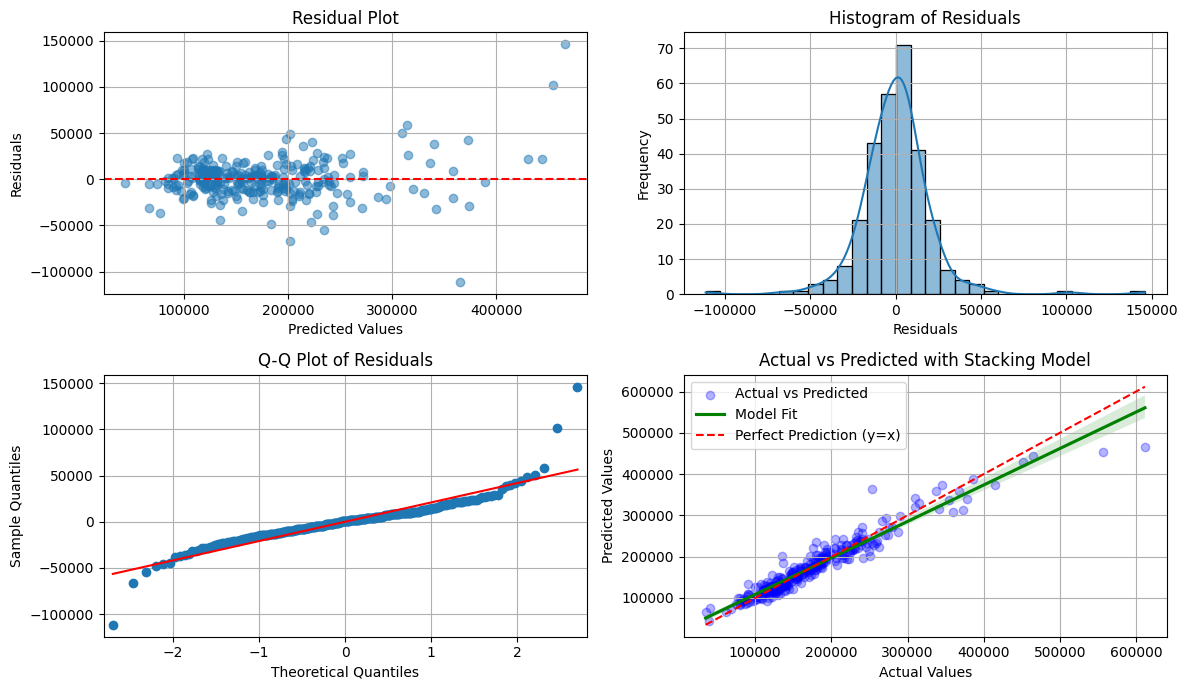


Detected polynomial order: 1
The relationship appears to be linear


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Assuming y_validate and y_pred_voting are already defined
# Calculate residuals
y_predict_blending = blended_model(X_validate)

residuals_blended = y_validate - y_predict_blending

# Set up the 2x2 grid layout
plt.figure(figsize=(12, 7))

# Residuals vs Predicted Values
plt.subplot(2, 2, 1)
plt.scatter(y_predict_blending, residuals_blended, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()

# Histogram of Residuals
plt.subplot(2, 2, 2)
sns.histplot(residuals_blended, bins=30, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid()


# Q-Q plot for normality check
plt.subplot(2, 2, 3)
sm.qqplot(residuals_blended, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Residuals')
plt.grid()

# Predicted vs Actual Values Scatter Plot
plt.subplot(2, 2, 4)
# Scatter plot
plt.scatter(y_validate, y_predict_blending, color='blue', alpha=0.3, label='Actual vs Predicted')
# Find best polynomial order automatically
best_order = find_best_order(y_validate, y_predict_blending)
# Plot the trend line with detected order
sns.regplot(x=y_validate, y=y_predict_blending, 
           scatter=False, 
           color='green',
           order=best_order,  # Using detected order
           line_kws={"linestyle": "-", 
                    "label": f"Model Trend (Order={best_order})"},
           label='Model Fit'
           )
# Perfect prediction line
plt.plot([y_validate.min(), y_validate.max()], 
         [y_validate.min(), y_validate.max()], 
         color='red', linestyle='--', label='Perfect Prediction (y=x)')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted with Stacking Model")
plt.legend()
plt.grid()


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Print the detected relationship type
print(f"\nDetected polynomial order: {best_order}")
if best_order == 1:
    print("The relationship appears to be linear")
else:
    print(f"The relationship appears to be non-linear (order {best_order})")

<br>So from residual analysis:

- **Residual plot**
&emsp; The residuals are scattered randomly around the horizontal line at zero, suggesting that the model's predictions are generally accurate. There's no clear pattern or trend, which is a good sign for the model's reliability.

- **Histogram of Residuals**
&emsp; The histogram shows a roughly bell-shaped distribution, which is desirable. This suggests that the residuals are normally distributed, which is a key assumption for many statistical tests. The histogram also confirms the presence of a few outliers, as seen in the residual plot even we are remove outlier but just roughly method to considering outlier detected. But afew outlier can make model stability.

- **Q-Q Plot of Residual**
&emsp; The points in the Q-Q plot generally follow the diagonal line, indicating that the residuals are approximately normally distributed. This is consistent with the histogram. And a few points deviate from the line, again highlighting the presence of outliers.

- **Actual vs. Predicted**:
&emsp; The green line representing the model's predictions being close to the perfect prediction line (dashed red line) suggests a good fit. However, if the model attempts to fit all points exactly, it may indicate overfitting, especially if the true relationship between the features and the target variable is not inherently linear.

- ### Test data ( Unseen data )

In [50]:
# Predict the SalePrice for the test set
y_pred_test = blended_model(X_test)

# Create a DataFrame for the output
submission = pd.DataFrame({
    'Id': X_test.index,  # Make sure X_test has an index that corresponds to IDs
    'SalePrice': y_pred_test
})

# Save the predictions to a CSV file
submission.to_csv('submission_blending.csv', index=False)

print("Predictions saved to 'submission_blending.csv'")

Predictions saved to 'submission_blending.csv'


<h2 id='closing-words'> Closing words </h2>

&emsp; Stacking and blending a model can improve model performance, but to increase the robustness of a model, we need to go deeper into outlier consideration and cross hyperparameter tuning that needs to take much time, and parameters in this challenge I use from the estimation of my experiment of hyperparameter tuning many times. That's why I need not to use cross-validation in this model.

&emsp; I hope this challenge will be useful for advance regression technique in regression problem.